# A/B testing of website landing pages 

## with awswrangler, Python SDK and AWS S3, Glue & Athena services¶

## System setup & data ingestion with AWS cloud

### AWS S3 Data Lake setup

In [2]:
bucketname = 'ab-testing-landing-page'

In [3]:
import boto3
import pandas as pd

s3 = boto3.client('s3')
s3.create_bucket(Bucket=bucketname)

{'ResponseMetadata': {'RequestId': 'TA8QZFFXT92MSZK5',
  'HostId': 'zVYwUq9zy7LnQz1ZesJBQgaV48gDhl8GaKYQr4+kaz/Bl3IG7NzLlbgBq3T4dtpBYx4qmGbl+jU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zVYwUq9zy7LnQz1ZesJBQgaV48gDhl8GaKYQr4+kaz/Bl3IG7NzLlbgBq3T4dtpBYx4qmGbl+jU=',
   'x-amz-request-id': 'TA8QZFFXT92MSZK5',
   'date': 'Wed, 03 Nov 2021 08:06:24 GMT',
   'location': '/ab-testing-landing-page',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/ab-testing-landing-page'}

In [4]:
s3.list_buckets()

{'ResponseMetadata': {'RequestId': 'TA8YV4630YYPFYJ3',
  'HostId': 'VSvrMQLd1AYX+QRexfJFt6MRU4f0UwCj0J+JMApYjwmlk0w2y/qDTOdk836njtdJjFI/qSdcECI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'VSvrMQLd1AYX+QRexfJFt6MRU4f0UwCj0J+JMApYjwmlk0w2y/qDTOdk836njtdJjFI/qSdcECI=',
   'x-amz-request-id': 'TA8YV4630YYPFYJ3',
   'date': 'Wed, 03 Nov 2021 08:06:24 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'ab-testing-landing-page',
   'CreationDate': datetime.datetime(2021, 11, 1, 12, 7, 17, tzinfo=tzutc())},
  {'Name': 'aws-athena-query-results-985046275345-us-east-1',
   'CreationDate': datetime.datetime(2021, 10, 28, 13, 28, 34, tzinfo=tzutc())},
  {'Name': 'awswrangler-cars',
   'CreationDate': datetime.datetime(2021, 10, 28, 11, 52, 54, tzinfo=tzutc())},
  {'Name': 'cf-templates-1i4g25d5y456l-us-east-1',
   'CreationDate': datetime.datetime(2021, 10, 26, 13, 40, 44, tzinfo=tzu

list our buckets and check our new bucket is there

In [5]:
[bucket['Name'] for bucket in s3.list_buckets()['Buckets']]

['ab-testing-landing-page',
 'aws-athena-query-results-985046275345-us-east-1',
 'awswrangler-cars',
 'cf-templates-1i4g25d5y456l-us-east-1',
 'destination-bucket-acg',
 'output-tranformed-user-data']

In [6]:
filename = 'ab_data.csv'

s3.upload_file(filename, bucketname, filename)

We assume that in the future our data originates from the website application directly and is Kinesis streamed and saved with the service Kinesis Data Firehosed as partitioned data into the data lake S3.

Now for this demo we have just the csv file, therefore we emulate the same by uploading this data via Pandas as date partitioned Parquet dataset into S3.


In [7]:
# prepare the data to be able to create meaningful partitions in S3

df=pd.read_csv('ab_data.csv')

df.sample(3)
len(df)

294478

Furthermore we expect to see scale up amounts of ab test data and prepare various columns that allow a range of time windows. Primary query parameter will be likely dates and date ranges so the date column will be included as well.

In [8]:
df.timestamp = pd.to_datetime(df.timestamp) # convert object type to datetime

In [9]:
df['week'] = df['timestamp'].dt.isocalendar().week
#df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
#df['date'] = df['timestamp'].dt.date
#df['month_year'] = df['timestamp'].dt.strftime('%Y-%m')

partition_cols=['year', 'week']

df.rename(columns = {'group':'grp'}, inplace = True) # rename for athena reserved strings compatibility
df.sample(3)

,user_id,timestamp,grp,landing_page,converted,week,year
43005,763099,2017-01-10 19:18:13.842170,control,old_page,0,2,2017
232745,889330,2017-01-17 08:57:12.863737,control,old_page,0,3,2017
80801,839423,2017-01-04 22:23:42.503421,control,old_page,1,1,2017


save pandas dataframe as date partitioned parquet dataset in the new S3 bucket

In [11]:
%%time

from datetime import date
import awswrangler as wr
import pandas as pd
import numpy as np

path = f"s3://{bucketname}/ab_data/"

wr.s3.to_parquet(
    df=df,
    path=path,
    dataset=True, # dataset mode required for partitioning the data
    mode='overwrite_partitions',
    #use_threads=True,
    partition_cols=partition_cols, # partitioning the data by time related cols
    #database='ab_testing',  # Athena/Glue database
    #table='app01_test01',  # Athena/Glue table
    s3_additional_kwargs={
        'ServerSideEncryption': 'aws:kms',
        'SSEKMSKeyId': 'b946ba2f-1a2a-4d66-9d85-83ada3523e33'
    }
)

Wall time: 15.9 s


{'paths': ['s3://ab-testing-landing-page/ab_data/year=2017/week=1/ac21aa2a19de4d518cf8b1a501bc8a87.snappy.parquet',
  's3://ab-testing-landing-page/ab_data/year=2017/week=2/ac21aa2a19de4d518cf8b1a501bc8a87.snappy.parquet',
  's3://ab-testing-landing-page/ab_data/year=2017/week=3/ac21aa2a19de4d518cf8b1a501bc8a87.snappy.parquet',
  's3://ab-testing-landing-page/ab_data/year=2017/week=4/ac21aa2a19de4d518cf8b1a501bc8a87.snappy.parquet'],
 'partitions_values': {'s3://ab-testing-landing-page/ab_data/year=2017/week=1/': ['2017',
   '1'],
  's3://ab-testing-landing-page/ab_data/year=2017/week=2/': ['2017', '2'],
  's3://ab-testing-landing-page/ab_data/year=2017/week=3/': ['2017', '3'],
  's3://ab-testing-landing-page/ab_data/year=2017/week=4/': ['2017', '4']}}

In [12]:
df = wr.s3.read_parquet(path, dataset=True) # important to read as dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  Int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   grp           294478 non-null  string        
 3   landing_page  294478 non-null  string        
 4   converted     294478 non-null  Int64         
 5   year          294478 non-null  category      
 6   week          294478 non-null  category      
dtypes: Int64(2), category(2), datetime64[ns](1), string(2)
memory usage: 12.4 MB


In [14]:
#df.date = pd.to_datetime(df.date).dt.date # set datetime data type for the column date
#df.date = pd.to_datetime(df.date) # set datetime data type for the column date

df.year = df.year.astype(int)
df.week = df.week.astype(int)

In [15]:
#df.query('20170101 < date < 20170105')

In [16]:
#df[(df['date'] > '2017-01-01') & (df['date'] < '2017-01-08')]

In [17]:
#df[df.user_id==679687]


### AWS Glue Crawling

prepare metadata in Glue Data catalog

In [18]:
dbname = 'ab_test'

if dbname not in wr.catalog.databases().values: 
    wr.catalog.create_database(dbname) 
    print(wr.catalog.databases()) 
else: 
    print("Database " + dbname + " already exists") 

Database ab_test already exists


In [19]:
column_types, partition_types = wr.catalog.extract_athena_types( 
  df=df, 
  index=False, 
  partition_cols=partition_cols
) 

print(column_types)
print(partition_types)

{'user_id': 'bigint', 'timestamp': 'timestamp', 'grp': 'string', 'landing_page': 'string', 'converted': 'bigint'}
{'year': 'int', 'week': 'int'}


In [20]:
tablename = "app01_test01"

if not wr.catalog.does_table_exist(database=dbname, table=tablename):
    wr.catalog.create_parquet_table( 
       table = tablename, 
       database = dbname, 
       path = path, 
       columns_types = column_types,
       partitions_types = partition_types,
       compression='snappy'
    )
else:
    print("Table " + tablename + " already exists") 

Table app01_test01 already exists


In [21]:
%%time

"""# important update!
res = wr.s3.store_parquet_metadata(
    path=path,
    database=dbname,
    table=tablename,
    dataset=True,
    mode="overwrite",
    dtype={"week": "int", "year": "int"}
)"""

Wall time: 5.71 s


In [22]:
wr.catalog.table(database=dbname, table=tablename) 

,Column Name,Type,Partition,Comment
0,user_id,bigint,False,
1,timestamp,timestamp,False,
2,grp,string,False,
3,landing_page,string,False,
4,converted,bigint,False,
5,year,int,True,
6,week,int,True,


force athena to update table partitions with an ALTER TABLE ... ADD PARTITION query, in order for later queries to work

In [23]:
"""import boto3
glue_client = boto3.client('glue')

response = glue_client.get_partitions(
 DatabaseName=dbname,
 TableName=tablename
)
partition_list = response['Partitions']"""

In [24]:
partition_list

[{'Values': ['2017', '2'],
  'DatabaseName': 'ab_test',
  'TableName': 'app01_test01',
  'CreationTime': datetime.datetime(2021, 11, 3, 9, 7, 4, tzinfo=tzlocal()),
  'StorageDescriptor': {'Columns': [{'Name': 'user_id', 'Type': 'bigint'},
    {'Name': 'timestamp', 'Type': 'timestamp'},
    {'Name': 'grp', 'Type': 'string'},
    {'Name': 'landing_page', 'Type': 'string'},
    {'Name': 'converted', 'Type': 'bigint'}],
   'Location': 's3://ab-testing-landing-page/ab_data/year=2017/week=2/',
   'InputFormat': 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat',
   'OutputFormat': 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat',
   'Compressed': False,
   'NumberOfBuckets': -1,
   'SerdeInfo': {'SerializationLibrary': 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe',
    'Parameters': {'serialization.format': '1'}},
   'BucketColumns': [],
   'SortColumns': [],
   'StoredAsSubDirectories': False},
  'CatalogId': '985046275345'},
 {'Values': ['2017',

In [25]:
partition_list[3]['Values'][1]

'4'

In [26]:
partition_list[1]['StorageDescriptor']['Location']

's3://ab-testing-landing-page/ab_data/year=2017/week=3/'

In [27]:
sql_string = "ALTER TABLE " + tablename + " ADD IF NOT EXISTS"
j = len(partition_list)
for i in range(0,j):
    sql_string = sql_string + "\n PARTITION (year='" + partition_list[i]['Values'][0] +"', week='" + partition_list[i]['Values'][1] +"') LOCATION '" + partition_list[i]['StorageDescriptor']['Location'] + "'"
    
print(sql_string)

ALTER TABLE app01_test01 ADD IF NOT EXISTS
 PARTITION (year='2017', week='2') LOCATION 's3://ab-testing-landing-page/ab_data/year=2017/week=2/'
 PARTITION (year='2017', week='3') LOCATION 's3://ab-testing-landing-page/ab_data/year=2017/week=3/'
 PARTITION (year='2017', week='1') LOCATION 's3://ab-testing-landing-page/ab_data/year=2017/week=1/'
 PARTITION (year='2017', week='4') LOCATION 's3://ab-testing-landing-page/ab_data/year=2017/week=4/'


In [28]:
# make sure that the partitions are read into athena
#sql1 = 'MSCK REPAIR TABLE' + tablename
#sql1 = "ALTER TABLE " + tablename + " ADD IF NOT EXISTS PARTITION (month_year='2017', date='2017-01-02') LOCATION '" + path + "'"
#sql1 = "ALTER TABLE " + tablename + " ADD IF NOT EXISTS PARTITION (month_year='2017')"
#sql1

In [29]:
#wr.athena.read_sql_query(sql = sql_string, database = dbname, ctas_approach = False) 

""


In [30]:
%%time 
#sql2 = "SELECT user_id, landing_page, timestamp, grp, date, converted from " + tablename + " WHERE date < CAST('2017-01-18' AS DATE) limit 10"
sql2 = "SELECT user_id, landing_page, timestamp, grp, converted from " + tablename + " WHERE week = 1"
sql2

Wall time: 0 ns


'SELECT user_id, landing_page, timestamp, grp, converted from app01_test01 WHERE week = 1'

In [31]:
#wr.athena.read_sql_query(sql = sql2, database = dbname, ctas_approach = False) 

,user_id,landing_page,timestamp,grp,converted
0,853541,new_page,2017-01-08 18:28:03.143,treatment,0
1,817355,new_page,2017-01-04 17:58:08.979,treatment,1
2,888545,new_page,2017-01-08 06:37:26.332,treatment,1
3,892356,new_page,2017-01-05 09:35:14.904,treatment,1
4,736159,new_page,2017-01-06 01:50:21.318,treatment,0
...,...,...,...,...,...
86053,769333,old_page,2017-01-04 20:47:53.297,control,0
86054,769858,new_page,2017-01-04 05:01:31.140,treatment,0
86055,870042,new_page,2017-01-02 21:06:59.518,treatment,0
86056,714517,new_page,2017-01-02 23:37:57.926,treatment,0


## Analysis of A/B test data

In [32]:
sql3 = "SELECT user_id, landing_page, timestamp, grp, converted from " + tablename 
df = wr.athena.read_sql_query(sql = sql3, database = dbname, ctas_approach = False) 

### Data Exploration

In [33]:
df['user_id'].nunique()


290584

In [34]:
df['converted'].mean()

0.11965919355605512

In [35]:
# data cleaning for obvious testing errors records that happened earlier
# the control group by definition is only allowed to see the old page and vice versa

df.query("(grp == 'control' and landing_page == 'new_page') or (grp == 'treatment' and landing_page == 'old_page')").shape[0]

3893

In [36]:
df = df.query("(grp == 'control' and landing_page == 'old_page') or (grp == 'treatment' and landing_page == 'new_page')") 
total = len(df)
total

290585

In [37]:
# check for duplicate users / by design each unique user is allowed to be counted only once in this test
print(df[df.duplicated(['user_id'])]['user_id'].unique())
df = df.drop_duplicates(['user_id'], keep='first')

<IntegerArray>
[773192]
Length: 1, dtype: Int64


In [38]:
nold, nnew = df.groupby(['grp'])['converted'].sum()

In [39]:
pold, pnew = df.groupby(['grp'])['converted'].mean()

In [40]:
count = df.groupby(['converted', 'grp'])['landing_page'].count()
count

converted  grp      
0          control      127785
           treatment    128046
1          control       17489
           treatment     17264
Name: landing_page, dtype: int64

In [41]:
grp_total = df.groupby('converted')['landing_page'].count()
grp_total

converted
0    255831
1     34753
Name: landing_page, dtype: int64

In [42]:
count / grp_total

converted  grp      
0          control      0.499490
           treatment    0.500510
1          control      0.503237
           treatment    0.496763
Name: landing_page, dtype: float64

Sampling new visits

In [50]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(nnew,pnew)
    old_page_converted = np.random.binomial(nold, pold)
    diff = new_converted/nnew - old_page_converted/nold
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   6.,  100.,  576., 1972., 3088., 2767., 1206.,  250.,   29.,
           6.]),
 array([-0.00826311, -0.00615893, -0.00405476, -0.00195058,  0.0001536 ,
         0.00225778,  0.00436196,  0.00646614,  0.00857032,  0.0106745 ,
         0.01277868]),
 <a list of 10 Patch objects>)

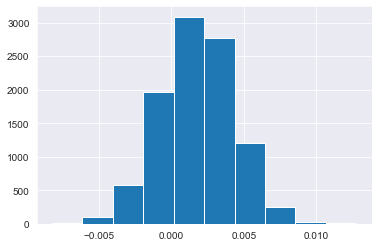

In [52]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(facecolor='w')
plt.hist(p_diffs)

discontinued for now due to minor AWS cloud cost shock at the billing cycle 🙈